In [200]:
import requests
import time
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Helper Functions

These functions train a model on your data and use cross validation to determine the average negative mean squared error. You do not have to edit these! However, it might make sense to add new helper functions here.

In [201]:
def scoreLinear(X, y):
    """Trains a linear regression model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    regr = linear_model.LinearRegression()
    scores = cross_val_score(regr, X, y, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [202]:
def scoreBoosting(X, y):
    """Trains a gradient boosting model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='squared_error')
    # clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='ls') # older versions

    scores = cross_val_score(clf, X, np.ravel(y), cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [203]:
def dataframeToXy(df, predict_column, feature_columns):
    """Convert the dataframe to a format usable for the ML algorithms"""
    X = df[feature_columns].values.reshape(-1, df[feature_columns].shape[1]) # all features
    y = df[[predict_column]].values.reshape(-1, 1) # values to predict
    return X, y

In [204]:
def runScoring(df, predict_column, feature_columns):
    """This runs both algorithms to determine the scores for all given features in the dataset.
    
    Parameters: 
    df (dataframe): dataframe with Score and features
    predict_column: name of the value to predict, e.g. 'Score'
    feature_columns: list of all column names that are to be used as features
  
    Returns: 
    linear: negative mean squared error of linear regression
    boost: negative mean squared error of boosting algorithm
    """
    X, y = dataframeToXy(df, predict_column, feature_columns)
    boost = scoreBoosting(X, y)
    linear = scoreLinear(X, y)
    return linear, boost

In [205]:
def runScoringSimple(df, predict_column):
    """Alternative to function above, this takes all the columns in the 
    dataframe as features except the single column which is used for the score.
    """
    all_feature_columns = list(df.columns)
    all_feature_columns.remove(predict_column)
    return runScoring(df, predict_column, all_feature_columns)

In [206]:
def createBaselineRandom(df, predict_column):
    """creates random features and returns the average score after 20 rounds"""
    np.random.seed(0)
    baseline = df[['Score']].copy()
    averageLinearScore = 0
    averageBoostingScore = 0
    rounds = 20
    for i in range(rounds):
        baseline['feature1'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature2'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature3'] = np.random.randint(0, 100, df.shape[0])
        lin, boost = runScoring(baseline, predict_column, ['feature1', 'feature2', 'feature3'])
        averageLinearScore += lin / rounds
        averageBoostingScore += boost / rounds
    print(f'linear   : {averageLinearScore}')
    print(f'boosting : {averageBoostingScore}')

In [207]:
def normalize_log(df_in, cols):
    """
    Apply log normalization (log1p) to specified columns in a dataframe.
    Returns a dataframe with log-normalized columns.
    """

    for col in cols:
        if col in df_in.columns:
            # Skip non-numeric columns
            if not pd.api.types.is_numeric_dtype(df_in[col]):
                continue

            # Handle negative values
            min_val = df_in[col].min()
            if min_val <= 0:
                # Shift all values to be positive
                shift = abs(min_val) + 1
                df_in[col] = np.log1p(df_in[col] + shift)
            else:
                # Apply log1p directly
                df_in[col] = np.log1p(df_in[col])
        else:
            print(f"Column {col} not found in dataframe.")

    return df_in

In [208]:
def normalize_min_max(df_in, cols):
    """
    Apply Min-Max normalization to specified columns in a dataframe.
    Returns a dataframe with normalized columns.
    """

    for col in cols:
        if col in df_in.columns:
            min_val = df_in[col].min()
            max_val = df_in[col].max()
            if max_val > min_val: # Avoid division by zero
                 df_in[col] = (df_in[col] - min_val) / (max_val - min_val)
            else:
                 df_in[col] = 0 # default
        else:
            print(f"Column {col} not found in dataframe.")
    return df_in

In [209]:
def standardize_data(df_in, columns):
    """
    Apply Z-normalization (standardization) to specified columns in a dataframe.
    Returns a dataframe with standardized columns.
    """

    scaler = StandardScaler()
    cols_to_scale = [col for col in columns if col in df_in.columns]
    if cols_to_scale:
         df_in[cols_to_scale] = scaler.fit_transform(df_in[cols_to_scale])
    else:
         print("Warning: No valid columns found for standardization.")
    return df_in

In [210]:
def rec_feature_elimination(df_in, predict_column, amt_features, use_boost=False):
    """Uses Recursive Feature Elimination to find the features with the biggest impact
    Adapted from example at
    https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
    """
    df_temp = df_in.copy()

    # Ensure only numeric features are considered
    numeric_cols = df_temp.select_dtypes(include=np.number).columns.tolist()
    if predict_column in numeric_cols:
        numeric_cols.remove(predict_column)
    else:
         raise ValueError(f"Score column '{predict_column}' must be a numeric column in the DataFrame.")


    if not numeric_cols:
        print("Error: No numeric feature columns available for RFE.")
        return []

    X = df_temp[numeric_cols].values
    y = df_temp[predict_column].values

    estimator = linear_model.LinearRegression()
    if use_boost:
        estimator = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='squared_error')
        y = np.ravel(y)


    selector = RFE(estimator, n_features_to_select=amt_features, step=1)
    selector = selector.fit(X, y)
    return np.array(numeric_cols)[selector.support_] # Get names of selected features

In [211]:
def add_polynominal_features(df_in, deg=2):
    """Function to add polynomial features for the passed dataframe.
    Returns a dataframe with polynomial features added.
    """
    poly = PolynomialFeatures(degree=deg, include_bias=True)
    feats = poly.fit_transform(df_in)
    feat_names = poly.get_feature_names_out(input_features=df_in.columns)
    return pd.DataFrame(feats, columns=feat_names, index=df_in.index)

In [212]:
def remove_collinear_features(df_in, threshold):
    """
    Remove collinear features from a DataFrame based on a correlation threshold.
    Method generated with ChatGPT
    Returns a new dataframe with the dropped values
    """

    # Compute absolute correlation matrix
    corr_matrix = df_in.corr().abs()

    # Mask the upper triangle (excluding the diagonal)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify columns to drop
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

    # Drop identified columns from original DataFrame
    reduced_df = df_in.drop(columns=to_drop)

    return reduced_df

# Load Data

Recommended: Make sure you have a column named 'Score', preferably as the first column, while the name of the municipality is the index. It is fine to use your previous notebook from assignment 1 to export the data to a .csv or excel and simply import the file here, you do not have to show the code for that. Your initial dataframe should look somewhat like the one below, with more features of course.

**Data preformatting:** Since the Model only works with features that are numbers two tactics were chosen: deleting values and encoding them. Since the Bezirk is already represented by number, the Kanton is always SO and PdA/Sol._2019 is always empty no new information can be gained from them. Therefore, those columns have been removed. Datum der Aufnahme on the other hand was encoded to amount of days since the first Gemeinde joined the canton. to prevent loss of a feature. Additionally missing data is replaced with the number 0.

In [213]:
df = pd.read_pickle("data/merged_data.pkl")


# Encode Datum der Aufnahme to days since first Aufnahme
df['Datum der Aufnahme'] = pd.to_datetime(df['Datum der Aufnahme'], format='%Y-%m-%d', errors='coerce')
earliest_date = df['Datum der Aufnahme'].min()
df['Days Since First Aufnahme'] = (df['Datum der Aufnahme'] - earliest_date).dt.days

# remove the Bezirksname, Kanton, PdA/Sol._2019
df.drop(columns=['Bezirksname', 'Kanton', 'PdA/Sol._2019', 'Datum der Aufnahme'], inplace=True)

# replace all values that are "X" with 0
df = df.map(lambda x: 0 if x == "X" else x).infer_objects(copy=False)

df

,Score,Hist.-Nummer,Bezirks-nummer,Gemeindecode,Einwohner_2019,Veränderung in %_2010-2019,Bevölkerungs-dichte pro km²_2019,Ausländer in %_2019,0-19 Jahre_2019,20-64 Jahre_2019,...,SP_2019,SVP_2019,EVP/CSP_2019,GLP_2019,BDP_2019,GPS_2019,Kleine Rechtsparteien_2019,Straftaten,percentage_first_sector,Days Since First Aufnahme
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Bolken,42,13723.0,1106.0,2514,595.0,9.778598,280.660377,5.042017,23.025210,62.521008,...,20.050761,23.519459,0.338409,6.852792,4.822335,11.336717,0.084602,20,inf,51975
Hüniken,48,13733.0,1106.0,2524,153.0,70.000000,150.000000,3.921569,24.183007,56.209150,...,20.618557,23.711340,0.515464,6.958763,1.546392,16.752577,0.257732,5,inf,51975
Beinwil (SO),85,11876.0,1110.0,2612,275.0,-8.940397,12.135922,7.272727,22.545455,55.272727,...,4.668675,25.451807,0.150602,1.957831,0.150602,7.078313,1.204819,9,68.217054,0
Kammersrohr,82,12650.0,1107.0,2549,32.0,-17.948718,33.684211,3.125000,12.500000,62.500000,...,10.185185,11.111111,0.000000,10.185185,0.925926,7.407407,11.111111,1,66.666667,0
Kienberg,66,12691.0,1105.0,2492,504.0,0.000000,59.085580,8.730159,19.246032,60.515873,...,10.381978,37.708129,2.056807,2.938296,2.154750,6.268364,0.979432,17,51.694915,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zuchwil,3,13743.0,1106.0,2534,9041.0,3.693084,1952.699784,43.689857,18.493529,63.200973,...,26.114263,20.674635,1.570097,8.032820,1.914506,12.753241,0.476094,789,0.124334,51975
Solothurn,14,10384.0,1109.0,2601,16933.0,5.396489,2696.337580,21.319317,15.644009,64.058348,...,24.851403,12.277776,0.944031,9.609747,1.750894,20.599231,0.317366,3861,0.064839,0
Olten,10,12486.0,1108.0,2581,18399.0,8.312239,1601.305483,29.278765,16.261753,65.106799,...,26.161744,16.126321,1.756124,8.693564,1.738112,20.097863,0.378242,2942,0.036337,0


These are the features that were used to create the original ranking in Assignment 1. Make sure these features are not in your dataset from now on. 
**TODO: Please write down your original features here!**

## Original Features
- Percentage of farmers -> percentage_first_sector
- Percentage of Swiss people -> 100 - (Ausländer in %_2019)
- Number of crimes -> Straftaten
- Population density -> Bevölkerungs-dichte pro km²_2019

## Related Features
As stated in the assignment, features that are related to the original features should also be removed. These are:
- Total employees -> Beschäftigte total_2018
- Employees in the first sector -> im 1. Sektor_2018
- Employees in the second sector -> im 2. Sektor_2018
- Employees in the third sector -> im 3. Sektor_2018
- Total number of workplaces -> Arbeitsstätten total_2018
- Workplaces in the first sector -> im 1. Sektor_2018.1
- Workplaces in the second sector -> im 2. Sektor_2018.1
- Workplaces in the third sector -> im 3. Sektor_2018.1

In [214]:
# removal of original features
df.drop(columns=['percentage_first_sector', 'Ausländer in %_2019', 'Straftaten', 'Bevölkerungs-dichte pro km²_2019'], inplace=True)

# remove of columns that were related to the original Features
df.drop(columns=['Beschäftigte total_2018', 'im 1. Sektor_2018', 'im 2. Sektor_2018', 'im 3. Sektor_2018', 'Arbeitsstätten total_2018', 'im 1. Sektor_2018.1', 'im 2. Sektor_2018.1', 'im 3. Sektor_2018.1'], inplace=True)

df

,Score,Hist.-Nummer,Bezirks-nummer,Gemeindecode,Einwohner_2019,Veränderung in %_2010-2019,0-19 Jahre_2019,20-64 Jahre_2019,65 Jahre und mehr_2019,Rohe Heiratssziffer_2019,...,FDP 2)_2019,CVP_2019,SP_2019,SVP_2019,EVP/CSP_2019,GLP_2019,BDP_2019,GPS_2019,Kleine Rechtsparteien_2019,Days Since First Aufnahme
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Bolken,42,13723.0,1106.0,2514,595.0,9.778598,23.025210,62.521008,14.453782,1.672241,...,16.920474,13.620981,20.050761,23.519459,0.338409,6.852792,4.822335,11.336717,0.084602,51975
Hüniken,48,13733.0,1106.0,2524,153.0,70.000000,24.183007,56.209150,19.607843,0.000000,...,14.432990,14.948454,20.618557,23.711340,0.515464,6.958763,1.546392,16.752577,0.257732,51975
Beinwil (SO),85,11876.0,1110.0,2612,275.0,-8.940397,22.545455,55.272727,22.181818,0.000000,...,21.536145,37.198795,4.668675,25.451807,0.150602,1.957831,0.150602,7.078313,1.204819,0
Kammersrohr,82,12650.0,1107.0,2549,32.0,-17.948718,12.500000,62.500000,25.000000,0.000000,...,23.148148,24.074074,10.185185,11.111111,0.000000,10.185185,0.925926,7.407407,11.111111,0
Kienberg,66,12691.0,1105.0,2492,504.0,0.000000,19.246032,60.515873,20.238095,1.966568,...,17.629775,17.825661,10.381978,37.708129,2.056807,2.938296,2.154750,6.268364,0.979432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zuchwil,3,13743.0,1106.0,2534,9041.0,3.693084,18.493529,63.200973,18.305497,3.332778,...,15.498379,10.615883,26.114263,20.674635,1.570097,8.032820,1.914506,12.753241,0.476094,51975
Solothurn,14,10384.0,1109.0,2601,16933.0,5.396489,15.644009,64.058348,20.297644,5.695639,...,19.743955,8.767919,24.851403,12.277776,0.944031,9.609747,1.750894,20.599231,0.317366,0
Olten,10,12486.0,1108.0,2581,18399.0,8.312239,16.261753,65.106799,18.631447,7.072521,...,15.751081,8.324328,26.161744,16.126321,1.756124,8.693564,1.738112,20.097863,0.378242,0


# Get a first baseline for your model with random values

In [215]:
# This code creates a baseline for your model, using random features
createBaselineRandom(df, 'Score')

linear   : -461.9609593322414
boosting : -536.5381768044549


**WARNING**: This uses the same dataframe for both the linear model and the boosting model. In your code you will want to use different ones for the different models. Your goal is to get both of these scores to as close as 0 as possible and most likely you will need to do different steps for linear regression and for gradient boosting and therefore have different features. 

# Get a second baseline by using all features you have

In [216]:
# this assumes we have a dataframe with a column named Score and all other columns are features.
# You might have to change this code if your dataframe looks different.

linear, boost = runScoringSimple(df, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

linear   : -191.1860500666951
boosting : -147.83943188917434


# Extend your features and add something of a geographic nature

Take the features you have loaded above and potentially extend it with the data from the gemeindeporträts 2021. Now you can extend this with some kind of geographic information. This can be pretty much anything that uses coordinates, height, relative position to other features etc. Try to find something reasonable that might help you, but don't worry if you find out during your feature engineering that it is not helpful, you are not required to use the feature for your final model.

# Get the coordinates of the Gemeinden
Use the API from geo.admin.ch to get the coordinates of the Gemeinden. These coordinates will them be used to create a new geographic feature.

In [217]:
# API URL for geo.admin.ch
API_URL = 'https://api3.geo.admin.ch/rest/services/api/SearchServer'

latitudes = []
longitudes = []

# Get the coordinates of each of the Gemeinden.
for name in df.index:
    params = {
        'type': 'locations',
        'origins': 'gg25',
        'searchText': str(name),
        'sr': '4326', # WGS 84
        'limit': 1 # Get the top Result
    }
    # Make the API call
    result = requests.get(API_URL, params=params).json()

    # Add the coordinates to the List
    if result.get('results'):
        attrs = result['results'][0]['attrs']
        longitudes.append(attrs['x'])
        latitudes.append(attrs['y'])
    # Error handling - should never be called
    else:
        longitudes.append(None)
        latitudes.append(None)

# Add the coordinates to the dataframe
df['Longitude'] = longitudes
df['Latitude'] = latitudes

df


,Score,Hist.-Nummer,Bezirks-nummer,Gemeindecode,Einwohner_2019,Veränderung in %_2010-2019,0-19 Jahre_2019,20-64 Jahre_2019,65 Jahre und mehr_2019,Rohe Heiratssziffer_2019,...,SP_2019,SVP_2019,EVP/CSP_2019,GLP_2019,BDP_2019,GPS_2019,Kleine Rechtsparteien_2019,Days Since First Aufnahme,Longitude,Latitude
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Bolken,42,13723.0,1106.0,2514,595.0,9.778598,23.025210,62.521008,14.453782,1.672241,...,20.050761,23.519459,0.338409,6.852792,4.822335,11.336717,0.084602,51975,7.663737,47.193565
Hüniken,48,13733.0,1106.0,2524,153.0,70.000000,24.183007,56.209150,19.607843,0.000000,...,20.618557,23.711340,0.515464,6.958763,1.546392,16.752577,0.257732,51975,7.636059,47.183060
Beinwil (SO),85,11876.0,1110.0,2612,275.0,-8.940397,22.545455,55.272727,22.181818,0.000000,...,4.668675,25.451807,0.150602,1.957831,0.150602,7.078313,1.204819,0,7.589023,47.354610
Kammersrohr,82,12650.0,1107.0,2549,32.0,-17.948718,12.500000,62.500000,25.000000,0.000000,...,10.185185,11.111111,0.000000,10.185185,0.925926,7.407407,11.111111,0,7.591982,47.256771
Kienberg,66,12691.0,1105.0,2492,504.0,0.000000,19.246032,60.515873,20.238095,1.966568,...,10.381978,37.708129,2.056807,2.938296,2.154750,6.268364,0.979432,0,7.965604,47.442192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zuchwil,3,13743.0,1106.0,2534,9041.0,3.693084,18.493529,63.200973,18.305497,3.332778,...,26.114263,20.674635,1.570097,8.032820,1.914506,12.753241,0.476094,51975,7.562047,47.206112
Solothurn,14,10384.0,1109.0,2601,16933.0,5.396489,15.644009,64.058348,20.297644,5.695639,...,24.851403,12.277776,0.944031,9.609747,1.750894,20.599231,0.317366,0,7.529796,47.208057
Olten,10,12486.0,1108.0,2581,18399.0,8.312239,16.261753,65.106799,18.631447,7.072521,...,26.161744,16.126321,1.756124,8.693564,1.738112,20.097863,0.378242,0,7.893518,47.339989


# Amount of Volg shops in the area
The new geographic feature is the amount of Volg shops in the area. This is done by using the Overpass API to get the amount of Volg shops in a radius of 5km around the coordinates of the center of the Gemeinde. This was gotten previously using the geo.admin API.

In [218]:
def count_volg_shops_near_municipality(lat, lon, radius=5000):
    """
    Count the number of Volg shops within a radius (in meters) of a coordinate point.

    Args:
        lat (float): Latitude of municipality center
        lon (float): Longitude of municipality center
        radius (int): Search radius in meters

    Returns:
        int: Number of Volg shops found
    """

    # Overpass API endpoint
    overpass_url = "https://overpass-api.de/api/interpreter"

    # Query to find Volg shops within radius
    overpass_query = f"""
    [out:json];
    (
      node["shop"]["name"~"Volg",i]
        (around:{radius},{lat},{lon});
      way["shop"]["name"~"Volg",i]
        (around:{radius},{lat},{lon});
      relation["shop"]["name"~"Volg",i]
        (around:{radius},{lat},{lon});
    );
    out center;
    """

    # Send the request to the Overpass API
    try:
        response = requests.post(overpass_url, data={"data": overpass_query})
        response.raise_for_status()  # Check for HTTP errors
        data = response.json()

        # Return the count of Volg shops
        return len(data.get("elements", []))

    # Handle errors
    except Exception as e:
        print(f"Error querying Overpass API: {e}")
        return 0

# Add Volg shop counts to the dataframe
df['amtVolg'] = 0

# Process each municipality with a delay to respect API rate limits
for idx, row in df.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        shops_count = count_volg_shops_near_municipality(row['Latitude'], row['Longitude'])
        df.at[idx, 'amtVolg'] = shops_count
        print(f"Found {shops_count} Volg shops near {idx}")
        time.sleep(1)  # Add delay to respect API rate limits


print("Volg shops count feature added to the dataframe")
# Save the dataframe with the new geographic feature -  because getting the feature takes quite long
df.to_pickle("data/data_with_geo_feature.pkl")

KeyboardInterrupt: 

# Do your own feature engineering here

Your goal is to find the right features to get both scores as close to 0 as possible. Add more columns to your dataframe through feature engineering and choose which ones of those you will use for the machine learning models. Use the methods discussed in class to improve your results even further.

In [219]:
df = pd.read_pickle("data/data_with_geo_feature.pkl")
df

,Score,Hist.-Nummer,Bezirks-nummer,Gemeindecode,Einwohner_2019,Veränderung in %_2010-2019,0-19 Jahre_2019,20-64 Jahre_2019,65 Jahre und mehr_2019,Rohe Heiratssziffer_2019,...,SVP_2019,EVP/CSP_2019,GLP_2019,BDP_2019,GPS_2019,Kleine Rechtsparteien_2019,Days Since First Aufnahme,Longitude,Latitude,amtVolg
Gemeindename,,,,,,,,,,,,,,,,,,,,,
Bolken,42,13723.0,1106.0,2514,595.0,9.778598,23.025210,62.521008,14.453782,1.672241,...,23.519459,0.338409,6.852792,4.822335,11.336717,0.084602,51975,7.663737,47.193565,2
Hüniken,48,13733.0,1106.0,2524,153.0,70.000000,24.183007,56.209150,19.607843,0.000000,...,23.711340,0.515464,6.958763,1.546392,16.752577,0.257732,51975,7.636059,47.183060,3
Beinwil (SO),85,11876.0,1110.0,2612,275.0,-8.940397,22.545455,55.272727,22.181818,0.000000,...,25.451807,0.150602,1.957831,0.150602,7.078313,1.204819,0,7.589023,47.354610,0
Kammersrohr,82,12650.0,1107.0,2549,32.0,-17.948718,12.500000,62.500000,25.000000,0.000000,...,11.111111,0.000000,10.185185,0.925926,7.407407,11.111111,0,7.591982,47.256771,1
Kienberg,66,12691.0,1105.0,2492,504.0,0.000000,19.246032,60.515873,20.238095,1.966568,...,37.708129,2.056807,2.938296,2.154750,6.268364,0.979432,0,7.965604,47.442192,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zuchwil,3,13743.0,1106.0,2534,9041.0,3.693084,18.493529,63.200973,18.305497,3.332778,...,20.674635,1.570097,8.032820,1.914506,12.753241,0.476094,51975,7.562047,47.206112,2
Solothurn,14,10384.0,1109.0,2601,16933.0,5.396489,15.644009,64.058348,20.297644,5.695639,...,12.277776,0.944031,9.609747,1.750894,20.599231,0.317366,0,7.529796,47.208057,4
Olten,10,12486.0,1108.0,2581,18399.0,8.312239,16.261753,65.106799,18.631447,7.072521,...,16.126321,1.756124,8.693564,1.738112,20.097863,0.378242,0,7.893518,47.339989,0


In [220]:
createBaselineRandom(df, 'Score')

linear   : -461.9609593322414
boosting : -536.5381768044549


In [221]:
linear, boost = runScoringSimple(df, 'Score')
print(f'linear   : {linear}')
print(f'boosting : {boost}')

# Store progress for visualization later, keeping both the successful and the failed attempts
progress = [
    ("All Features", (linear, boost))
]


linear   : -220.30207810599293
boosting : -148.42778085134515


# Feature Normalization - Log Normalization
Log normalization is a common technique used to transform skewed data into a more normal distribution and can help remove variance. This had a strong effect on the linear model and reduced the error by more than 50%. The boosting model stayed almost unaffected by this. Therefore, the gain from this transformation seems to be model dependent.

In [222]:
df_log = df.copy()
df_log = df_log.drop(columns=['Score'], axis=1)


df_log = normalize_log(df_log, df_log.columns)
df_log['Score'] = df['Score']
lin_log, boost_log = runScoringSimple(df_log, 'Score')
print(f'    Log Linear   : {lin_log}')
print(f'    Log Boosting : {boost_log}')

progress.append(("Log Transform", (lin_log, boost_log)))


    Log Linear   : -91.37190397420996
    Log Boosting : -148.78231817927355


# Feature Normalization - MinMax Normalization
Scaling features to [0,1] yields only a small (~2.5%) error drop for a linear model and has virtually no effect on the boosted model, showing that simple min-max scaling is far less impactful for these features than a log normalization.

In [223]:
df_minmax = df.copy()
df_minmax = df_minmax.drop(columns=['Score'], axis=1)

df_minmax = normalize_min_max(df_minmax, df_minmax.columns)
df_minmax['Score'] = df['Score']
lin_mm, boost_mm = runScoringSimple(df_minmax, 'Score')
print(f'    MinMax Linear   : {lin_mm}')
print(f'    MinMax Boosting : {boost_mm}')
progress.append(("MinMax Scale", (lin_mm, boost_mm)))

    MinMax Linear   : -214.59539319971609
    MinMax Boosting : -148.42778085134515


# Feature Normalization - Data Standardization (Z-Normalization)
Standardizing each feature to zero mean and unit variance cuts the linear model’s error by only 2.5% and leaves the boosted model unchanged. Showing that z-normalization, like min-max scaling, offers minimal gains compared to a log transform.


In [224]:
df_std = df.copy()
df_std = df_std.drop(columns=['Score'], axis=1)

df_std = standardize_data(df_std, df_std.columns)
df_std['Score'] = df['Score']
lin_std, boost_std = runScoringSimple(df_std, 'Score')
print(f'    Std Linear   : {lin_std}')
print(f'    Std Boosting : {boost_std}')
progress.append(("Standard Scale", (lin_std, boost_std)))

    Std Linear   : -214.5952592758931
    Std Boosting : -148.42778085134515


# Feature Normalization - Result
Since the log normalization had the biggest effect on the linear model and left the boosted model unchanged, it seems to be the best choice for this notebook and will therefore be used as the bases for the next steps.

# Feature Tranformation - One-Hot Encoding
Do One-Hot encoding for the Bezirksnummer, since there are multiple Gemeinden in the same Bezirk.
Expanding this categorical variables into one-hot vectors almost doubles the linar model's error, while the boosted model stays virtually the same. Therefore, one-hot encoding this feature can overwhelm simple linear regressions but has little effect on the boosted model.


In [225]:
# Create a new dataframe for one-hot encoding
df_encoded = df_log.copy()

# One-hot encode the Bezirks-nummer column
df_encoded = pd.get_dummies(df_encoded, columns=['Bezirks-nummer'], prefix='Bezirk')

# Run scoring with the encoded features
lin_enc, boost_enc = runScoringSimple(df_encoded, 'Score')
print(f'    Encoded Linear   : {lin_enc}')
print(f'    Encoded Boosting : {boost_enc}')
progress.append(("OneHot Encoded (Bezirk)", (lin_enc, boost_enc)))

    Encoded Linear   : -103.83016795892969
    Encoded Boosting : -148.94526160201278


# Feature Combinations - Polynomial Features
Adding polynomial features to the dataset can help capture non-linear relationships between features. This can help models fit more complex datasets, but adding to many of these features can lead to overfitting.
The log normalization was taken as the basis for this.


## Attempt 1 - run on entire dataframe

In [226]:
df_poly = df_log.copy()
df_poly = df_poly.drop(columns=['Score'], axis=1)

# Add polynomial features
df_poly = add_polynominal_features(df_poly[df_poly.columns], deg=2)
df_poly['Score'] = df['Score']

lin_poly, boost_poly = runScoringSimple(df_poly, 'Score')
print(f'    Poly Linear   : {lin_poly}')
print(f'    Poly Boosting : {boost_poly}')
progress.append(("Poly Features ", (lin_poly, boost_poly)))

    Poly Linear   : -64.13982707723274
    Poly Boosting : -127.58131932745478


## Attempt 2 - run on features: 'Siedlungsfläche in %_2004/09', 'Neu gebaute Wohnungen pro 1000 Einwohner_2018' , 'Leerwohnungs-ziffer_2020','Landwirtschafts-fläche in %_2004/09'
The assumption beeing that the space for building, farming and the empty and new buildings correlate.

In [227]:
df_poly_2 = df_log.copy()
df_poly_2 = df_poly_2.drop(columns=['Score'], axis=1)

# Add polynomial features
df_poly_2 = add_polynominal_features(df_poly_2[['Siedlungsfläche in %_2004/09', 'Neu gebaute Wohnungen pro 1000 Einwohner_2018', 'Leerwohnungs-ziffer_2020','Landwirtschafts-fläche in %_2004/09']], deg=2)
df_poly_2['Score'] = df['Score']

lin_poly_2, boost_poly_2 = runScoringSimple(df_poly_2, 'Score')
print(f'    Poly Linear   : {lin_poly_2}')
print(f'    Poly Boosting : {boost_poly_2}')
progress.append(("Poly Features 2", (lin_poly_2, boost_poly_2)))

    Poly Linear   : -137.42869664644195
    Poly Boosting : -187.21335818316575


## Attempt 3 - run on features: 'Einwohner_2019', 'Veränderung in %_2010-2019', 'Days Since First Aufnahme'
Assumption beeing that there is a correlation between when the Gemeinde joined the canton, the inhabitants and the change in inhabitants.

In [228]:
df_poly_3 = df_log.copy()
df_poly_3 = df_poly_3.drop(columns=['Score'], axis=1)

# Add polynomial features
df_poly_3 = add_polynominal_features(df_poly_3[['Einwohner_2019', 'Veränderung in %_2010-2019', 'Days Since First Aufnahme']], deg=2)
df_poly_3['Score'] = df['Score']

lin_poly_3, boost_poly_3 = runScoringSimple(df_poly_3, 'Score')
print(f'    Poly Linear   : {lin_poly_3}')
print(f'    Poly Boosting : {boost_poly_3}')
progress.append(("Poly Features 3", (lin_poly_3, boost_poly_3)))

    Poly Linear   : -244.25232405227732
    Poly Boosting : -271.47631979939734


## Attempt 4 - run on features: 'Einwohner_2019', '20-64 Jahre_2019', '65 Jahre und mehr_2019', 'Sozialhilfequote_2019', 'Durchschnittliche Haushaltsgrösse in Personen_2019'
Assumption beeing that I can capture social wellfare with these features.

In [229]:
df_poly_4 = df_log.copy()
df_poly_4 = df_poly_4.drop(columns=['Score'], axis=1)

# Add polynomial features
df_poly_4 = add_polynominal_features(df_poly_4[['Einwohner_2019', '20-64 Jahre_2019', '65 Jahre und mehr_2019', 'Sozialhilfequote_2019', 'Durchschnittliche Haushaltsgrösse in Personen_2019']], deg=2)
df_poly_4['Score'] = df['Score']

lin_poly_4, boost_poly_4 = runScoringSimple(df_poly_4, 'Score')
print(f'    Poly Linear   : {lin_poly_4}')
print(f'    Poly Boosting : {boost_poly_4}')
progress.append(("Poly Features 4", (lin_poly_4, boost_poly_4)))

    Poly Linear   : -176.99851414890202
    Poly Boosting : -154.82475480712176


## Attempt 5 - run on features: 'amtVolg', 'Einwohner_2019', 'Neu gebaute Wohnungen pro 1000 Einwohner_2018'
Assumption beeing that if there are more people there should be more shops

In [230]:
df_poly_5 = df_log.copy()
df_poly_5 = df_poly_5.drop(columns=['Score'], axis=1)

# Add polynomial features
df_poly_5 = add_polynominal_features(df_poly_5[['amtVolg', 'Einwohner_2019', 'Neu gebaute Wohnungen pro 1000 Einwohner_2018']], deg=2)
df_poly_5['Score'] = df['Score']

lin_poly_5, boost_poly_5 = runScoringSimple(df_poly_5, 'Score')
print(f'    Poly Linear   : {lin_poly_5}')
print(f'    Poly Boosting : {boost_poly_5}')
progress.append(("Poly Features 5", (lin_poly_5, boost_poly_5)))

    Poly Linear   : -118.60303972577803
    Poly Boosting : -272.52219037474487


# Feature Selection based on Collinearity
The polynominal feature selection based on the entire dataframe yielded the best results but also created a lot of features. Therefore RFE on this dataframe would take to long. This feature selection will eliminate features based on their correlation, under the assuption that if two features are very similar to each other one of those can probaly be removed without influencing the model too much.

In [231]:
df_coll = df_poly.copy()
df_coll = df_coll.drop(columns=['Score'], axis=1)


df_coll = remove_collinear_features(df_coll, 0.9)
df_coll['Score'] = df['Score']

lin_coll, boost_coll = runScoringSimple(df_coll, 'Score')
print(f'    Poly Linear   : {lin_coll}')
print(f'    Poly Boosting : {boost_coll}')
progress.append(("Poly Features coll", (lin_coll, boost_coll)))

    Poly Linear   : -58.97939168590664
    Poly Boosting : -139.2842236561043


# Recursive Feature Elimination (RFE)
RFE is a method to select features by recursively considering smaller and smaller sets of features. It uses the model accuracy to identify which attributes contribute the most to predicting the target attribute. It makes sense to apply this method since it helps to eliminate features that are not useful for the model. This especially applies in this case since there are a lot of different features in the dataframe.
The dataframe used for this is the one-hot encoded one, since it has the most features and therefore the most potential to eliminate features that are not useful.
Since the optimal amount of features is not known, and may be different for the linear model and the boosted model, RFE is run for all feature counts from 1 to 20. The best results are stored and printed at the end.

## Attempt 1  - with one hot encoding

In [232]:
best_lin_mse = float('-inf')  # Start with worst possible score
best_boost_mse = float('-inf') # Start with worst possible score
best_lin_count = 0
best_boost_count = 0
best_lin_features = []
best_boost_features = []

max_features = 20  # Maximum of 20 features will be keept
feature_range = range(1, max_features + 1)  # Test all feature counts from 1 to max

print(f"Running RFE with feature counts from 1 to {max_features}...")
for count in feature_range:
    print(f"Testing with {count} features...")

    # Run RFE for linear model
    rfe_features_lin = rec_feature_elimination(df_encoded, 'Score', count, use_boost=False)
    lin_score, _ = runScoring(df_encoded, 'Score', rfe_features_lin)

    # Run RFE for boosting model
    rfe_features_boost = rec_feature_elimination(df_encoded, 'Score', count, use_boost=True)
    _, boost_score = runScoring(df_encoded, 'Score', rfe_features_boost)

    # Track best results for linear model
    if lin_score > best_lin_mse:
        best_lin_mse = lin_score
        best_lin_count = count
        best_lin_features = rfe_features_lin

    # Track best results for boosting model
    if boost_score > best_boost_mse:
        best_boost_mse = boost_score
        best_boost_count = count
        best_boost_features = rfe_features_boost

# Print final results
print("\n--- Best RFE Results ---")
print(f"Best Linear Model (with {best_lin_count} features): {best_lin_mse}")
print(f"Selected features: {best_lin_features}")

print(f"\nBest Boosting Model (with {best_boost_count} features): {best_boost_mse}")
print(f"Selected features: {best_boost_features}")

# Add best results to progress tracker
progress.append((f"RFE one hot encoding (Lin:{best_lin_count}, Boost:{best_boost_count})", (best_lin_mse, best_boost_mse)))

Running RFE with feature counts from 1 to 20...
Testing with 1 features...
Testing with 2 features...
Testing with 3 features...
Testing with 4 features...
Testing with 5 features...
Testing with 6 features...
Testing with 7 features...
Testing with 8 features...
Testing with 9 features...
Testing with 10 features...
Testing with 11 features...
Testing with 12 features...
Testing with 13 features...
Testing with 14 features...
Testing with 15 features...
Testing with 16 features...
Testing with 17 features...
Testing with 18 features...
Testing with 19 features...
Testing with 20 features...

--- Best RFE Results ---
Best Linear Model (with 17 features): -38.38910573188664
Selected features: ['Gemeindecode' 'Einwohner_2019' 'Veränderung in %_2010-2019'
 '20-64 Jahre_2019' 'Anzahl Privathaushalte_2019'
 'Durchschnittliche Haushaltsgrösse in Personen_2019'
 'Gesamtfläche in km² 1)_2016' 'Siedlungsfläche in %_2004/09'
 'Landwirtschafts-fläche in %_2004/09' 'Wald und Gehölze in %_2004/09'


# Attempt 2 - with polynominal Features

In [194]:
best_lin_mse = float('-inf')  # Start with worst possible score
best_boost_mse = float('-inf') # Start with worst possible score
best_lin_count = 0
best_boost_count = 0
best_lin_features = []
best_boost_features = []

max_features = 20  # Maximum of 20 features will be keept
feature_counts = [10, 14, 17, 20]  # Testing 10, 14 (middle point), 17, and 20 features

print(f"Running RFE with feature counts: {feature_counts}...")
for count in feature_counts:
    print(f"Testing with {count} features...")

    # Run RFE for linear model
    rfe_features_lin = rec_feature_elimination(df_coll, 'Score', count, use_boost=False)
    lin_score, _ = runScoring(df_coll, 'Score', rfe_features_lin)

    # Run RFE for boosting model
    rfe_features_boost = rec_feature_elimination(df_coll, 'Score', count, use_boost=True)
    _, boost_score = runScoring(df_coll, 'Score', rfe_features_boost)

    # Track best results for linear model
    if lin_score > best_lin_mse:
        best_lin_mse = lin_score
        best_lin_count = count
        best_lin_features = rfe_features_lin

    # Track best results for boosting model
    if boost_score > best_boost_mse:
        best_boost_mse = boost_score
        best_boost_count = count
        best_boost_features = rfe_features_boost

# Print final results
print("\n--- Best RFE Results ---")
print(f"Best Linear Model (with {best_lin_count} features): {best_lin_mse}")
print(f"Selected features: {best_lin_features}")

print(f"\nBest Boosting Model (with {best_boost_count} features): {best_boost_mse}")
print(f"Selected features: {best_boost_features}")

# Add best results to progress tracker
progress.append((f"RFE - Polynominal Features (Lin:{best_lin_count}, Boost:{best_boost_count})", (best_lin_mse, best_boost_mse)))

Running RFE with feature counts from 1 to 20...
Testing with 1 features...


KeyboardInterrupt: 

# Results
The results were collected troughout the

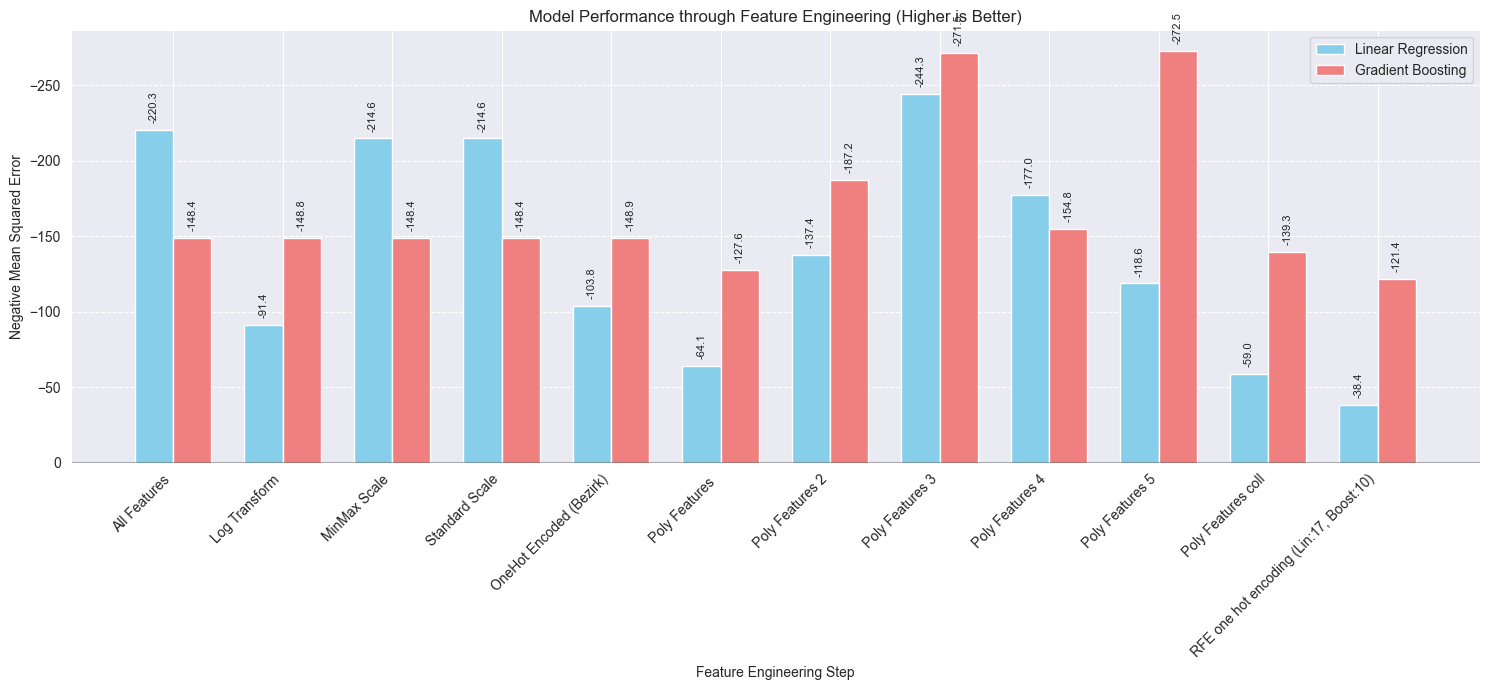

In [233]:

progress_df = pd.DataFrame([(p[0], p[1][0], p[1][1]) for p in progress], columns=['Step', 'Linear_Score', 'Boosting_Score'])

plt.figure(figsize=(15, 7))
bar_width = 0.35
index = np.arange(len(progress_df))


bar1 = plt.bar(index - bar_width/2, progress_df['Linear_Score'], bar_width, label='Linear Regression', color='skyblue')
bar2 = plt.bar(index + bar_width/2, progress_df['Boosting_Score'], bar_width, label='Gradient Boosting', color='lightcoral')

plt.xlabel('Feature Engineering Step')
plt.ylabel('Negative Mean Squared Error')
plt.title('Model Performance through Feature Engineering (Higher is Better)')
plt.xticks(index, progress_df['Step'], rotation=45, ha="right")


plt.gca().invert_yaxis()

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--')

for i, score in enumerate(progress_df['Linear_Score']):
    plt.annotate(f'{score:.1f}', xy=(i - bar_width/2, score),
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='bottom', fontsize=8, rotation=90)

for i, score in enumerate(progress_df['Boosting_Score']):
    plt.annotate(f'{score:.1f}', xy=(i + bar_width/2, score),
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()


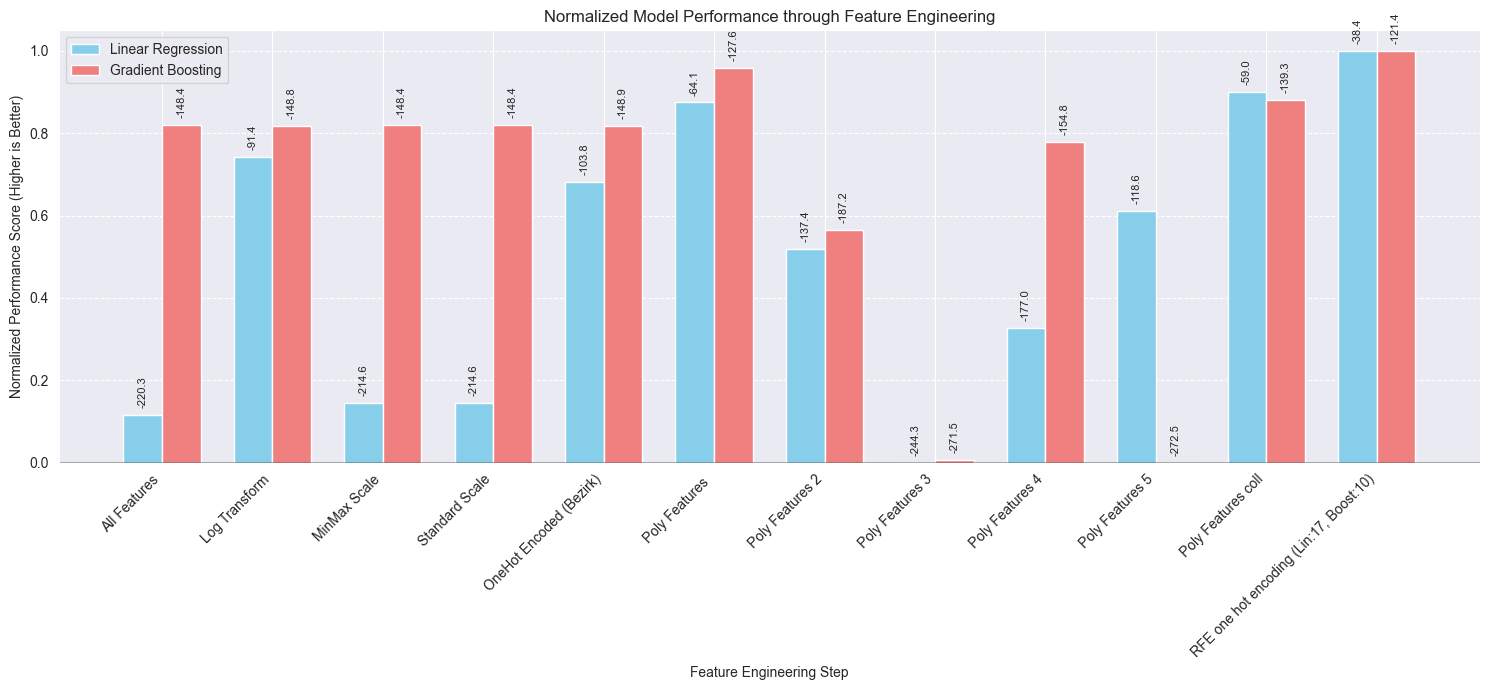

In [234]:
# Create a DataFrame from the progress list
progress_df = pd.DataFrame([(p[0], p[1][0], p[1][1]) for p in progress], columns=['Step', 'Linear_Score', 'Boosting_Score'])

# Normalize scores to a 0-1 scale for better comparison
min_linear = progress_df['Linear_Score'].min()
max_linear = progress_df['Linear_Score'].max()
min_boosting = progress_df['Boosting_Score'].min()
max_boosting = progress_df['Boosting_Score'].max()

progress_df['Linear_Normalized'] = (progress_df['Linear_Score'] - min_linear) / (max_linear - min_linear)
progress_df['Boosting_Normalized'] = (progress_df['Boosting_Score'] - min_boosting) / (max_boosting - min_boosting)

# Plotting the normalized scores
plt.figure(figsize=(15, 7))
bar_width = 0.35
index = np.arange(len(progress_df))

bar1 = plt.bar(index - bar_width/2, progress_df['Linear_Normalized'], bar_width,
               label='Linear Regression', color='skyblue')
bar2 = plt.bar(index + bar_width/2, progress_df['Boosting_Normalized'], bar_width,
               label='Gradient Boosting', color='lightcoral')

plt.xlabel('Feature Engineering Step')
plt.ylabel('Normalized Performance Score (Higher is Better)')
plt.title('Normalized Model Performance through Feature Engineering')
plt.xticks(index, progress_df['Step'], rotation=45, ha="right")

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--')

# Add the original score values as annotations
for i, (norm, score) in enumerate(zip(progress_df['Linear_Normalized'], progress_df['Linear_Score'])):
    plt.annotate(f'{score:.1f}', xy=(i - bar_width/2, norm),
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='bottom', fontsize=8, rotation=90)

for i, (norm, score) in enumerate(zip(progress_df['Boosting_Normalized'], progress_df['Boosting_Score'])):
    plt.annotate(f'{score:.1f}', xy=(i + bar_width/2, norm),
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()